## Variational Zero-inflated Gaussian Processes 

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import time
import pickle

from onofftf.main import Param, DataSet, GaussKL, KernSE, GPConditional
from onofftf.utils import modelmanager
from gpflow import transforms
import matplotlib as mpl
import matplotlib.gridspec as gridspec

float_type = tf.float64
jitter_level = 1e-5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

modelPath = "models/onoff.ckpt"

In [2]:
import scipy.io as sio
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x']
Ytrain = matdata['y']


** Load simulated dataset **

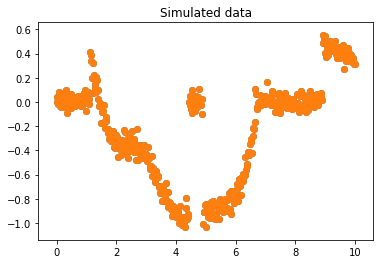

In [4]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

**Train specs & variable initializations**

In [5]:
num_iter       = 30000    # no. of optimization iterations 
num_inducing_f = 20       # no. of inducing f
num_inducing_g = 20       # no. of inducing g
num_data       = Xtrain.shape[0] # no. of observations
num_minibatch  = 100

init_fkell = 0.3 # kernle parameter initalizations 
init_fkvar = 10.

init_gkell = .3
init_gkvar = 5.

init_noisevar = 0.01

q_diag = False    # diagonal assumption for u_f & u_g
include_f_mu = False
init_Zf = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing_f+1,endpoint=False),0).transpose()
init_Zg = np.delete(np.linspace(min(Xtrain),max(Xtrain),num_inducing_g+1,endpoint=False),0).transpose()
init_Zf = init_Zf.reshape(-1,1)
init_Zg = init_Zg.reshape(-1,1)

init_u_fm = np.random.randn(num_inducing_f,1)*0.01
init_u_gm = np.random.randn(num_inducing_g,1)*0.01

if q_diag:
    init_u_fs_sqrt = np.ones(num_inducing_f).reshape(1,-1).T
    init_u_gs_sqrt = np.ones(num_inducing_g).reshape(1,-1).T
else:
    init_u_fs_sqrt = np.diag(np.ones(num_inducing_f))
    init_u_gs_sqrt = np.diag(np.ones(num_inducing_g))

kern_param_learning_rate = 1e-3
indp_param_learning_rate = 1e-2

**declare tensorflow variables and placeholders**

In [6]:
# ****************************************************************
# define tensorflow variables and placeholders
# ****************************************************************
X = tf.placeholder(dtype = float_type)
Y = tf.placeholder(dtype = float_type)

with tf.name_scope("f_kern"):
    fkell = Param(init_fkell,transform=transforms.Log1pe(),
                   name="lengthscale",learning_rate = kern_param_learning_rate,summ=False)
    fkvar = Param(init_fkvar,transform=transforms.Log1pe(),
                   name="variance",learning_rate = kern_param_learning_rate,summ=False)

fkern = KernSE(fkell,fkvar)

with tf.name_scope("g_kern"):
    gkell = Param(init_gkell,transform=transforms.Log1pe(),
                   name="lengthscale",learning_rate = kern_param_learning_rate,summ=False)
    gkvar = Param(init_gkvar,transform=transforms.Log1pe(),
                   name="variance",learning_rate = kern_param_learning_rate,summ=False)

gkern = KernSE(gkell,gkvar)

with tf.name_scope("likelihood"):
    noisevar = Param(init_noisevar,transform=transforms.Log1pe(),
                     name="variance",learning_rate = kern_param_learning_rate,summ=False)

with tf.name_scope("f_ind"):
    Zf = Param(init_Zf,name="z",learning_rate = indp_param_learning_rate)
    u_fm = Param(init_u_fm,name="value",learning_rate = indp_param_learning_rate)
    if q_diag:
        u_fs_sqrt = Param(init_u_fs_sqrt,transforms.positive,name="variance",learning_rate = indp_param_learning_rate)
    else:
        u_fs_sqrt = Param(init_u_fs_sqrt,transforms.LowerTriangular(init_u_fs_sqrt.shape[0]),name="variance",learning_rate = indp_param_learning_rate)
    
with tf.name_scope("g_ind"):
    Zg = Param(init_Zg,name="z",learning_rate = indp_param_learning_rate)
    u_gm = Param(init_u_gm,name="value",learning_rate = indp_param_learning_rate)
    
    if include_f_mu:
        f_mu = Param(init_f_mu,name="fmu",learning_rate = indp_param_learning_rate,summ=False)
        
    if q_diag:
        u_gs_sqrt = Param(init_u_gs_sqrt,transforms.positive,name="variance",learning_rate = indp_param_learning_rate) 
    else:
        u_gs_sqrt = Param(init_u_gs_sqrt,transforms.LowerTriangular(init_u_gs_sqrt.shape[0]),name="variance",learning_rate = indp_param_learning_rate)

** Define model build functions **

In [7]:
def build_prior_kl(u_fm,u_fs_sqrt,fkern,Zf,
                   u_gm,u_gs_sqrt,gkern,Zg):
    
    kl = GaussKL(u_fm.get_tfv(),u_fs_sqrt.get_tfv(),fkern.K(Zf.get_tfv())) + \
         GaussKL(u_gm.get_tfv(),u_gs_sqrt.get_tfv(),gkern.K(Zg.get_tfv()))
    
    return kl

def variational_expectations(Y,fmu,fvar,fmuvar,noisevar):
    return -0.5 * np.log(2 * np.pi) - 0.5 * tf.log(noisevar) \
            - 0.5 * (tf.square(Y - fmu) + fvar + fmuvar) / noisevar

def build_predict(Xnew,u_fm,u_fs_sqrt,fkern,Zf,u_gm,u_gs_sqrt,gkern,Zg,f_mu=None):
    # Get conditionals
    # returns mean, variance for marginal distributions q(f) and q(g)
    # q(f) = \int q(f|u_f) q(u_f) du_f
    # q(f) = N(f|A*u_fm,Kfnn + A(u_fs - Kfmm)t(A))  A = Kfnm*inv(Kfmm)
    fmean, fvar = GPConditional(Xnew,Zf.get_tfv(), fkern, u_fm.get_tfv(),full_cov=False,
                                q_sqrt=u_fs_sqrt.get_tfv(),whiten=False)

    gmean, gvar = GPConditional(Xnew,Zg.get_tfv(), gkern, u_gm.get_tfv(),full_cov=False,
                                q_sqrt=u_gs_sqrt.get_tfv(),whiten=False)
    if f_mu is not None:
        fmean = fmean + f_mu.get_tfv()

    # probit transformed expectations for  gamma
    ephi_g, ephi2_g, evar_phi_g = probit_expectations(gmean, gvar)

    # compute augmented f
    # from above computations we have
    # p(f)   = N(f| A*u_fm, Kfnn + A(u_fs - Kfmm)t(A))  A = Kfnm*inv(Kfmm)
    # p(f|g) = N(f| diag(ephi_g)* A*u_fm, diag(evar_phi_g)) * (Kfnn + A(u_fs - Kfmm)t(A)))
    gfmean = tf.multiply(ephi_g, fmean)
    gfvar = tf.multiply(ephi2_g, fvar)
    gfmeanu = tf.multiply(evar_phi_g, tf.square(fmean))

    # return mean and variancevectors of following in order -
    # augmented f, f, g, \Phi(g)
    return gfmean, gfvar, gfmeanu, fmean, fvar, gmean, gvar, ephi_g, evar_phi_g


def probit_expectations(gmean, gvar):
    def normcdf(x):
        return 0.5 * (1.0 + tf.erf(x / np.sqrt(2.0))) * (1. - 2.e-3) + 1.e-3

    def owent(h, a):
        h = tf.abs(h)
        term1 = tf.atan(a) / (2 * np.pi)
        term2 = tf.exp((-1 / 2) * (tf.multiply(tf.square(h), (tf.square(a) + 1))))
        return tf.multiply(term1, term2)

    z = gmean / tf.sqrt(1. + gvar)
    a = 1 / tf.sqrt(1. + (2 * gvar))

    cdfz = normcdf(z)
    tz = owent(z, a)

    ephig = cdfz
    ephisqg = (cdfz - 2. * tz)
    evarphig = (cdfz - 2. * tz - tf.square(cdfz))

    # clip negative values from variance terms to zero
    ephisqg = (ephisqg + tf.abs(ephisqg)) / 2.
    evarphig = (evarphig + tf.abs(evarphig)) / 2.

    return ephig, ephisqg, evarphig

** Build lower bound**

In [8]:
# get kl term
with tf.name_scope("kl"):
    kl = build_prior_kl(u_fm,u_fs_sqrt,fkern,Zf,
                        u_gm,u_gs_sqrt,gkern,Zg)
with tf.name_scope("model_build"):
    if include_f_mu:
        gfmean, gfvar, gfmeanu, fmean, fvar, gmean, gvar, pgmean, pgvar = build_predict(X,u_fm,u_fs_sqrt,fkern,Zf,u_gm,u_gs_sqrt,gkern,Zg,f_mu)
    else:
        gfmean, gfvar, gfmeanu, fmean, fvar, gmean, gvar, pgmean, pgvar = build_predict(X,u_fm,u_fs_sqrt,fkern,Zf,u_gm,u_gs_sqrt,gkern,Zg)

# compute likelihood
with tf.name_scope("var_exp"):
    var_exp = tf.reduce_sum(variational_expectations(Y,gfmean,gfvar,gfmeanu,noisevar.get_tfv()))
    # mini-batch scaling
    scale =  tf.cast(num_data, float_type) / tf.cast(num_minibatch, float_type)
    var_exp_scaled = var_exp * scale

# final lower bound
with tf.name_scope("cost"):
    cost =  -(var_exp_scaled - kl)

** Define optimizer op**

In [9]:
all_var_list = tf.trainable_variables()
all_lr_list = [var._learning_rate for var in all_var_list]

train_opt_group = []

for group_learning_rate in set(all_lr_list):
    _ind_bool = np.where(np.isin(np.array(all_lr_list),group_learning_rate))[0]
    group_var_list = [all_var_list[ind] for ind in _ind_bool]
    group_tf_optimizer = tf.train.AdamOptimizer(learning_rate = group_learning_rate)
    group_grad_list = tf.gradients(cost,group_var_list)
    group_grads_and_vars = list(zip(group_grad_list,group_var_list))


    group_train_op = group_tf_optimizer.apply_gradients(group_grads_and_vars)
    train_opt_group.append({'names':[var.name for var in group_var_list],
                            'vars':group_var_list,
                            'learning_rate':group_learning_rate,
                            'grads':group_grad_list,
                            'train_op':group_train_op})

train_op = tf.group(*[group['train_op'] for group in train_opt_group])


In [10]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [11]:
train_data = DataSet(Xtrain,Ytrain)

In [ ]:
print('{:>16s}'.format("iteration"),'{:>16s}'.format("objective"),'{:>16s}'.format("var_exp"),'{:>16s}'.format("kl"))

for i in range(num_iter):
    batch = train_data.next_batch(num_minibatch)
    try:    
        sess.run([train_op],feed_dict={X : batch[0],Y : batch[1]})
        
        if i % 2000 == 0:
            _cost    = cost.eval({X : Xtrain,Y : Ytrain})
            _var_exp = var_exp.eval({X : Xtrain,Y :Ytrain})
            _kl      = kl.eval({X : Xtrain,Y : Ytrain})
            print('{:>16d}'.format(i),'{:>16.3f}'.format(_cost),'{:>16.3f}'.format(_var_exp),'{:>16.3f}'.format(_kl))
            
    except KeyboardInterrupt as e:
        print("Stopping training")
        break
        
modelmngr = modelmanager(saver, sess, modelPath)
modelmngr.save()
# modelmngr.load()

In [ ]:
print("Noise variance   = " + str(noisevar.get_tfv().eval()))
print("Kf lengthscales  = " + str(fkell.get_tfv().eval()))
print("Kf variance      = " + str(fkvar.get_tfv().eval()))
print("Kg lengthscales  = " + str(gkell.get_tfv().eval()))
print("Kg variance      = " + str(gkvar.get_tfv().eval()))

** Mode build visualization **

In [ ]:
pred_std = fmean.eval({X:Xtrain}) 
pred_onoff = gfmean.eval({X:Xtrain}) 

In [ ]:
from matplotlib import ticker

mpl.rcParams['figure.figsize'] = (11.0,10.0)
mpl.rcParams.update({'font.size': 20})

_X = Xtrain.copy()
_Y = Ytrain.copy()

_Zf = Zf.get_tfv().eval()
_u_fm = u_fm.get_tfv().eval()
_u_fs_sqrt = u_fs_sqrt.get_tfv().eval()

_Zg = Zg.get_tfv().eval()
_u_gm = u_gm.get_tfv().eval()
_u_gs_sqrt = u_gs_sqrt.get_tfv().eval()

_variance = noisevar.get_tfv().eval()

_fkell = fkell.get_tfv().eval()
_fkvar = fkvar.get_tfv().eval()
_gkell = gkell.get_tfv().eval()
_gkvar = gkvar.get_tfv().eval()


####################################################
# plot data and model fit
_X = _X.flatten()
_Y = _Y.flatten()
_Zf = _Zf.flatten()
_Zg = _Zg.flatten()
_u_fm = _u_fm.flatten()
_u_gm = _u_gm.flatten()
_gfmean = gfmean.eval({X:Xtrain}).flatten()
_fmean = fmean.eval({X:Xtrain}).flatten()
_fvar = fvar.eval({X:Xtrain}).flatten()
_pgmean = pgmean.eval({X:Xtrain}).flatten()
_pgvar = pgvar.eval({X:Xtrain}).flatten()
_gmean = gmean.eval({X:Xtrain}).flatten()
_gvar = gvar.eval({X:Xtrain}).flatten()

_kf = fkern.Ksymm(X).eval({X:Xtrain})
_kg = gkern.Ksymm(X).eval({X:Xtrain})
_kpg = _pgmean.reshape(-1,1) * _pgmean.reshape(1,-1)
_kfg = _kpg * _kf


gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, 0:-1])
ax2 = plt.subplot(gs[1, 0:-1])
ax3 = plt.subplot(gs[2, 0:-1])
ax4 = plt.subplot(gs[3, 0:-1])
ax5 = plt.subplot(gs[0, -1])
ax6 = plt.subplot(gs[1, -1])
ax7 = plt.subplot(gs[2, -1])
ax8 = plt.subplot(gs[3, -1])


# plot y
ax1.plot(_X,_gfmean,'-',color='#ff7707')
y1 = (_gfmean-1.5*((np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)) + np.sqrt(_variance)))
y2 = (_gfmean+1.5*((np.sqrt(_fvar) * _pgmean +  np.sqrt(_pgvar)*(1-_pgmean)) + np.sqrt(_variance)))
ax1.fill_between(_X,y1,y2,facecolor='#ff7707',alpha=0.5)
ax1.scatter(_X,_Y,s=8,
         color='black',alpha=0.7)
ax1.set_xlim(0,10)
# ax1.set_ylabel("Data" + r"$\mathbf{y}|\mathbf{f}$")
ax1.set_title("(a) Predictive function \n"+r"$\mathbf{y}$",fontsize=18)
ax1.set_yticks([-1,0,1], [])
ax1.set_xticks([], [])

# plot f and f|g
ax2.plot(_X,_fmean,'-',color='#008b62',label=r"$f$")
f1 = (_fmean-1.5*np.sqrt(_fvar))
f2 = (_fmean+1.5*np.sqrt(_fvar))
ax2.fill_between(_X,f1,f2,facecolor='#008b62',alpha=0.5)
ax2.plot(_Zf,_u_fm,
         marker='o',linestyle = 'None',
         markeredgecolor = 'None',
         markerfacecolor='#008b62',alpha=0.7) #,label = 'uf (optimized)')

ax2.plot(_X,_gfmean,'-',color='#ff7707',label=r"$f|g$")
f3 = (_gfmean-1.5*(np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)))
f4 = (_gfmean+1.5*(np.sqrt(_fvar) * _pgmean + np.sqrt(_pgvar)*(1-_pgmean)))
ax2.fill_between(_X,f3,f4,facecolor='#ff7707',alpha=0.5)

ax2.set_xlim(0,10)
# ax2.set_ylabel("Augmnted "+ r"$\mathbf{f}|\mathbf{g}$",fontsize=18)
ax2.set_xticks([], [])
ax2.set_yticks([-1,0,1], [])
ax2.set_title("(c) Sparse latent function \n"+ r"$\mathbf{f}|\mathbf{g}$",fontsize=18)
ax2.legend(loc="lower right",ncol=1,fontsize=18)

# plot phi(gamma)
ax3.plot(_X,_pgmean,'-',color='#003366')
pg1 = (_pgmean-2*np.sqrt(_pgvar))
pg2 = (_pgmean+2*np.sqrt(_pgvar))
ax3.fill_between(_X,pg1,pg2,facecolor='#6684a3',alpha=0.7)
ax3.axhline(y=0.5,linestyle='--',color='#333333')
ax3.set_xlim(0,10)
ax3.set_title("(e) Probit support function \n" + r"$\Phi(\mathbf{g})$",fontsize=18)
ax3.set_xticks([], [])
# ax3.set_ylabel("Support " + r"$\Phi(\mathbf{g})$",fontsize=18)

# plot gamma
ax4.plot(_X,_gmean,'-',color='#003366')
ax4.plot(_Zg,_u_gm,
         marker='o',linestyle = 'None',
         markeredgecolor = 'None',
         markerfacecolor='#003366',alpha=0.8) #,label = 'ug (optimized)')
g1 = (_gmean-2*np.sqrt(_gvar))
g2 = (_gmean+2*np.sqrt(_gvar))
ax4.fill_between(_X,g1,g2,facecolor='#6684a3',alpha=0.7)
# ax4.set_ylabel("Latent  " +r"$\mathbf{g}$",fontsize=18)
ax4.axhline(y=0.0,linestyle='--',color='#333333')
ax4.set_title("(g) Latent function \n" +r"$\mathbf{g}$",fontsize=18)
ax4.set_xlim(0,10)
# plt.title('kernel lengthscale = %.3f, variance = %.3f' % (klg,ksg))

im5 = ax5.imshow(_kfg,cmap="viridis")
cb = plt.colorbar(im5,ax=ax5,fraction=0.046, pad=0.03,extend="max")
ax5.set_title("(b) Sparse kernel \n" + r"$\Phi(\mathbf{g}) \Phi(\mathbf{g})^T \circ K_f$",fontsize=18)
ax5.set_xticks([], [])
ax5.set_yticks([], [])
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()


im6 = ax6.imshow(_kf,cmap="viridis")
cb = plt.colorbar(im6,ax=ax6,fraction=0.046, pad=0.03,extend="max")
ax6.set_title("(d) Latent kernel \n"+r"$K_f$",fontsize=18)
ax6.set_xticks([], [])
ax6.set_yticks([], [])
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()


im7 = ax7.imshow(_kpg,cmap="viridis")
cb = plt.colorbar(im7,ax=ax7,fraction=0.046, pad=0.03,extend="max")
ax7.set_title("(f) Probit kernel \n" + r"$\Phi(\mathbf{g}) \Phi(\mathbf{g})^T$",fontsize=18)
ax7.set_xticks([], [])
ax7.set_yticks([], [])
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()


im8 = ax8.imshow(_kg,cmap="viridis")
cb =  plt.colorbar(im8,ax=ax8,fraction=0.046, pad=0.03,extend="max")
ax8.set_title("(h) Latent kernel \n"+r"$K_g$",fontsize=18)
ax8.set_xticks([], [])
ax8.set_yticks([], [])
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()

plt.tight_layout()
plt.subplots_adjust(hspace = 0.5,wspace=0.1)
plt.savefig("00_01_toy.png")
plt.show()
